In [20]:
from IPython.display import display, Image
import IPython.display as ipd
# import fluidsynth
from midi2audio import FluidSynth
import glob
import numpy as np
import pathlib
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import pretty_midi
import tensorflow as tf

from matplotlib import pyplot as plt

# Tomb added
import time
import copy
import random
import sys
from music21 import midi
import subprocess

In [21]:
#Download Chorales
data_dir = pathlib.Path('/Volumes/MAGIC1/CS50/myMusicGen/data/chorales')
if not data_dir.exists():
  tf.keras.utils.get_file(
      'midi',
      origin='https://github.com/jamesrobertlloyd/infinite-bach/tree/master/data/chorales/midi',
      extract=True,
      cache_dir='.', cache_subdir='data',
  )
filenames = glob.glob(str(data_dir/'**/*.mid*'))
print('Number of files:', len(filenames))

Number of files: 498


In [22]:
class UnsupportedMidiFileException(Exception):
  "Unsupported MIDI File"

In [23]:
class WrongWindowSize(Exception):
    def __init__(self, window_size):
        self.message = f"Window Size must be between 1 and 62!! Given size: {window_size}"
        super().__init__(self.message)

In [24]:
"""Tomb made a pretty useful function"""
def check_pianoroll_dim(pianoroll):
        rows = len(pianoroll)  # This gives the number of rows
        columns = len(pianoroll[0])  # This assumes all rows have the same length

        print("Number of rows:", rows) # represents sequence length
        print("Number of columns:", columns) # represents the 4 octave range in midi 36-83
        print("Total dimesions of this pianoroll is", rows*columns)

In [25]:
"""Tomb made to check if there is a single one, all zeros, or multiple ones in the pitch vector"""

def check_ones_zeros(array):
    count_ones = np.count_nonzero(array == 1)
    count_zeros = np.count_nonzero(array == 0)

    if count_ones == 1 and count_zeros == array.size - 1:
        # print("There is only one '1' and the rest are '0's in the array.")
        return True
    elif count_zeros == array.size:
        # print("All elements in the array are '0's.")
        return True
    else:
        # print("There are either multiple '1's or different values in the array.")
        return False

In [26]:
def get_musicScore(filename):
  musescore_path = "/Applications/MuseScore 4.app/Contents/MacOS/mscore"  # Path to the MuseScore executable

  midi_file_path = filename

  # Construct the command to open the MuseScore file
  command = [musescore_path, midi_file_path]

  # Execute the command
  subprocess.run(command)

In [28]:
"""Read_Midi 2"""

def read_midi(filename, sop_alto, seqlen):
  
  def get_pianoroll(midi, nn_from, nn_thru, seqlen, tempo):
    pianoroll = midi.get_piano_roll(fs=2*tempo/60) # shape(128, 1262) This is the core line which makes this matrix based on 8th note
    if pianoroll.shape[1] < seqlen:
        raise UnsupportedMidiFileException

    pianoroll = pianoroll[nn_from:nn_thru, 0:seqlen] # (48, 64) Pinoroll's value still NOT binary since it has velocity
    
    binary_pianoroll = np.heaviside(pianoroll, 0) # converting as a binary matrix
    transposed_pianoroll = np.transpose(binary_pianoroll) #(64, 48)
    # transposed_pianoroll = np.transpose(pianoroll)
    # return binary_pianoroll
    return transposed_pianoroll # type numpy.ndarray

  
  # read midi file
  midi = pretty_midi.PrettyMIDI(filename)

  # An Exception error is thrown if there is a modulation(key change)
  if len(midi.key_signature_changes) !=1:
    raise UnsupportedMidiFileException

  # The Exception error thrown when tempo changes
  tempo_time, tempo = midi.get_tempo_changes()
  if len(tempo) != 1:
    raise UnsupportedMidiFileException
  if sop_alto:
    # The exception thrown if there are less than 2 parts
    if len(midi.instruments) < 2:
      raise UnsupportedMidiFileException
    # Get pianoRoll returns numpy.ndarray
    pr_s = get_pianoroll(midi.instruments[0], 36, 84, seqlen, tempo[0])
    pr_a = get_pianoroll(midi.instruments[1], 36, 84, seqlen, tempo[0])
    pr_b = get_pianoroll(midi.instruments[2], 36, 84, seqlen, tempo[0])
    wholePart = get_pianoroll(midi, 36, 84, seqlen, tempo[0])
    
    
    return pr_s, pr_a, pr_b, wholePart # All numpy.ndarray including keymode  

In [29]:
"""read generatd midi file"""
def read_melody_midi(filename, seqlen):

    def get_pianoroll(midi, nn_from, nn_thru, seqlen, tempo):
        pianoroll = midi.get_piano_roll(fs=2*tempo/60) # shape(128, 1262) This is the core line which makes this matrix based on 8th note
        if pianoroll.shape[1] < seqlen:
            raise UnsupportedMidiFileException

        pianoroll = pianoroll[nn_from:nn_thru, 0:seqlen] # (48, 64) Pinoroll's value still NOT binary since it has velocity
        
        binary_pianoroll = np.heaviside(pianoroll, 0) # converting as a binary matrix
        transposed_pianoroll = np.transpose(binary_pianoroll) #(64, 48)
        
        # print("trans pr", transposed_pianoroll)
        return transposed_pianoroll # type numpy.ndarray
    
     # read midi file
    midi = pretty_midi.PrettyMIDI(filename)

    # The Exception error thrown when tempo changes
    tempo_time, tempo = midi.get_tempo_changes()
    if len(tempo) != 1:
        raise UnsupportedMidiFileException
   
    # Get pianoRoll returns numpy.ndarray
    melody = get_pianoroll(midi.instruments[0], 36, 84, seqlen, tempo[0])
    
    return melody


In [30]:
"""Window"""

np.set_printoptions(threshold=np.inf) # Show the entire print, esp Matrix

x_all = [] # 
y_all_alt = [] 
y_all_bass=[] 
files = [] # Number of files 498 but for collected files, there are 3 files that SKIPPED so we'll only see 495 files. E.g (495, int, int)
# keymodes = [] 

raw_seq_length =64
window_size = 2

try:
  if 62 < window_size or window_size < 1:
    raise WrongWindowSize(window_size)
except WrongWindowSize as e:
  print(e)  
  sys.exit()

for file in glob.glob(str(data_dir/"**/*.mid*")):
  files.append(file)
  try:
    #make a window to get sequence 
    sop_data, alt_data, bass_data, whole_data = read_midi(file, sop_alto=True, seqlen=raw_seq_length)
    x_all.append(sop_data)
    y_all_alt.append(alt_data)
    y_all_bass.append(bass_data)

  # throw exception for midi data which can not be used
  except UnsupportedMidiFileException:
    print("nah")


print(check_pianoroll_dim(y_all_bass))



nah
nah
nah
Number of rows: 495
Number of columns: 64
Total dimesions of this pianoroll is 31680
None


In [31]:
input_data = np.array(x_all) 
output_data_alt = np.array(y_all_alt)
output_data_bass=np.array(y_all_bass)
print("input data shape",input_data.shape)
print("alt data shape",output_data_alt.shape)
print("bass data shape",output_data_bass.shape)
print("")

i_train, i_test = train_test_split(range(len(input_data)),test_size=int(len(input_data)/2)) 
x_train = input_data[i_train]
x_test = input_data[i_test] 
print("x_train shape",x_train.shape)
print("x_tet shape",x_test.shape)
print("")

y_train_alt = output_data_alt[i_train] 
y_test_alt = output_data_alt[i_test] 
print("y_train alt",y_train_alt.shape)
print("y_test alt",y_test_alt.shape)
print("|")


y_train_bass = output_data_bass[i_train] 
y_test_bass = output_data_bass[i_test] 
print("y_train bass",y_train_bass.shape)
print("y_test bass",y_test_bass.shape)

input data shape (495, 64, 48)
alt data shape (495, 64, 48)
bass data shape (495, 64, 48)

x_train shape (248, 64, 48)
x_tet shape (247, 64, 48)

y_train alt (248, 64, 48)
y_test alt (247, 64, 48)
|
y_train bass (248, 64, 48)
y_test bass (247, 64, 48)


In [32]:
seq_length = x_train.shape[1] # Sequence size 64
pitch_range = x_train.shape[2] # int 48 the pitch range
print(x_train.shape[1])
print(x_train.shape[2])

64
48


In [33]:
# Define input layer
input_layer = tf.keras.layers.Input(shape=(seq_length, pitch_range)) # shape=(None, 64, 48)
# Shared layers
lstm1 = tf.keras.layers.LSTM(units=128, return_sequences=True)(input_layer)
batch_norm1 = tf.keras.layers.BatchNormalization()(lstm1)
lstm2 = tf.keras.layers.LSTM(units=64, return_sequences=True)(batch_norm1)
lstm3 = tf.keras.layers.LSTM(units=32, return_sequences=True)(lstm2)
lstm4 = tf.keras.layers.LSTM(units=16,return_sequences=True)(lstm3)
batch_norm2 =tf.keras.layers.BatchNormalization()(lstm4)

# Output layer for alto , shape=(None, 48)
output_alt = tf.keras.layers.Dense(pitch_range, activation='sigmoid', name='output_alt')(batch_norm2)

# Output layer for bass , shape=(None, 48)
output_bass = tf.keras.layers.Dense(pitch_range, activation='sigmoid', name='output_bass')(batch_norm2)

# Define the model with two outputs
model = tf.keras.Model(inputs=input_layer, outputs=[output_alt, output_bass])

# Compile the model
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss={'output_alt': 'binary_crossentropy', 'output_bass': 'binary_crossentropy'}, metrics=['accuracy'])

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 64, 48)]             0         []                            
                                                                                                  
 lstm_4 (LSTM)               (None, 64, 128)              90624     ['input_2[0][0]']             
                                                                                                  
 batch_normalization_2 (Bat  (None, 64, 128)              512       ['lstm_4[0][0]']              
 chNormalization)                                                                                 
                                                                                                  
 lstm_5 (LSTM)               (None, 64, 64)               49408     ['batch_normalization_2[

In [ ]:
# Train the model

callbacks = [tf.keras.callbacks.ModelCheckpoint(
        filepath="./training_checkpoints/ckpt_{epoch}",
        save_weights_only=True
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor="loss",
        patience=5,
        verbose=1,
        restore_best_weights=True
    )]

epochs = 500
batch_size = 64

# model.evaluate(x_train, y_train, return_dict=True)

history = model.fit(
    x_train, 
    {"output_alt": y_train_alt, "output_bass": y_train_bass}, 
    batch_size=batch_size, 
    epochs=epochs, 
    callbacks=callbacks,
    validation_data=(x_test,
                      {"output_alt": y_test_alt, "output_bass":y_test_bass})
                      )

model.evaluate(x_train, 
               {"output_alt": y_train_alt, "output_bass": y_train_bass}, 
               return_dict=True)

In [27]:
def make_yPred(x_test:np.array):
    # print("Before expansion", x_test.shape)
    input = np.expand_dims(x_test, axis=0)
    # print("After expansion", input.shape)
    prediction = model.predict(input, verbose="mute")
    
    return prediction 

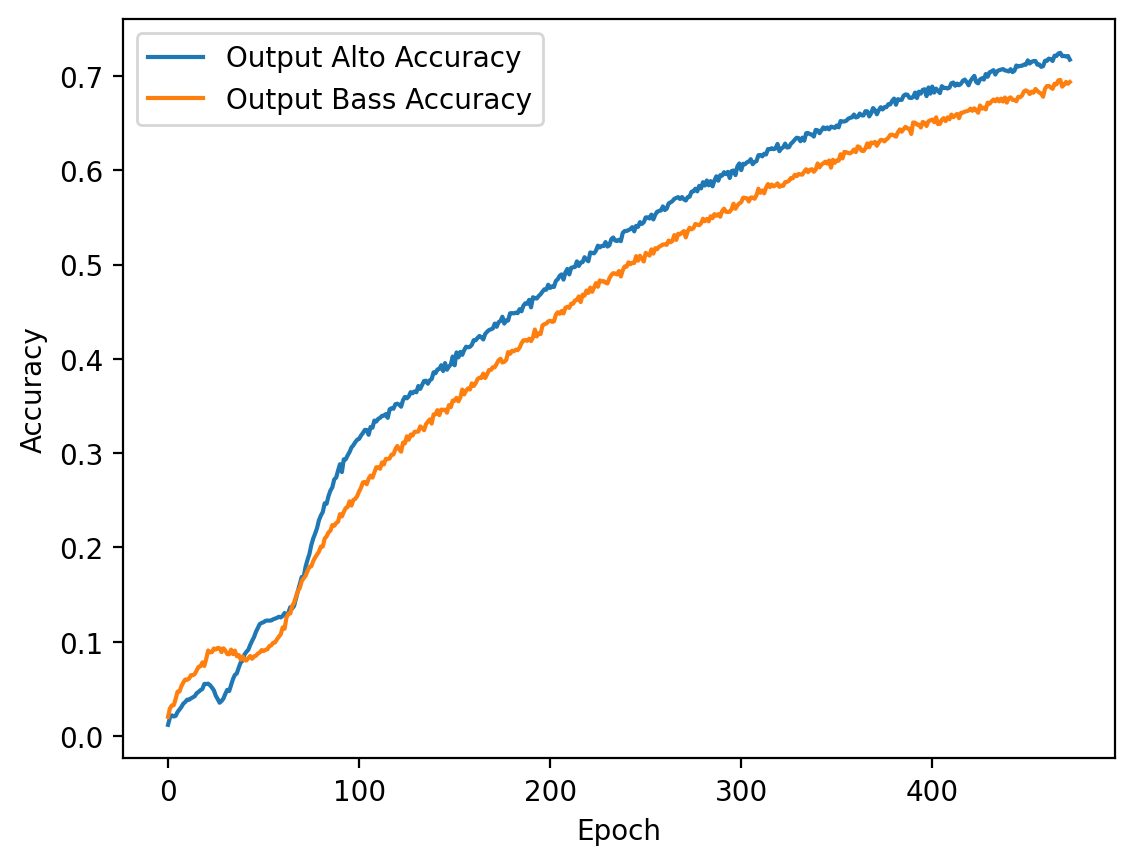

In [35]:
plt.plot(history.epoch, history.history['output_alt_accuracy'], label='Output Alto Accuracy')
plt.plot(history.epoch, history.history['output_bass_accuracy'], label='Output Bass Accuracy')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend() #"legend" is a small box or area within the plot that provides information about the elements being displayed.
plt.show()

In [36]:
"""Play Midi2"""

_SAMPLING_RATE = 16000
# make a fucntion to be able to do so
def play_midi(x_test:np.array, y_pred: np.array, filename): #x_test(2, 49), y_pred (62, 49)
  
  def make_midi(x_test:np.array, y_pred:np.array, filename):
      midi = pretty_midi.PrettyMIDI(resolution=480)
      instr = pretty_midi.Instrument(program=1)
      
      duration_balance=0.5 # Only for y 
      # desired_beat=0.5 # mute this and unmute random art_balance if you want dynamics
      velocity_balance=100 # mute  this and unmute velocity_balance if you want dynamics
      
      # values = [0.125, 0.25,0.5, 1, 2] # Note representation: 16th, 8th, quater, half, whole 
      # weights = [0.3, 0.7, 0.5, 0.3, 0.1] # weights corresponding to the note value above
      values = [0.5] # simple 4 beats 
      weights = [1] 
      total_weight = sum(weights)
      normalized_weights = [w / total_weight for w in weights] #  [0.13636363636363635, 0.22727272727272727, 0.3181818181818181, 0.18181818181818182, 0.09090909090909091, 0.045454545454545456] =total 0.9999999999999999
      random.seed()
      
      prev_start = 0
      for index, test_vector in enumerate(x_test): 
        for i in range(len(test_vector)): # the test_vector shape is similar to prPred   
            if test_vector[i] > 0.5:
                # print("x test pitch:", i, "| value:", test_vector[i])
                
                desired_beat=random.choices(values, weights=normalized_weights)[0] # make art_balance fixed 0.5 to get 8th notes 
                velocity_balance=0
                if 0 <= i <= 21:
                  velocity_balance = random.randint(110, 116)
                elif 11 <= i <= 33:
                  velocity_balance = random.randint(72, 110)
                else:
                  velocity_balance = random.randint(85, 112)
                print("desired_beat ",desired_beat)
                print("index", index)
                print("---")
                
                start = prev_start
                # start = prev_start
                end = start + desired_beat
                instr.notes.append(pretty_midi.Note(start=start,
                                                        end=end,
                                                        pitch=36+i,
                                                        velocity=velocity_balance)) 
                start = prev_start+(desired_beat)
                prev_start=start

      prev_start1=prev_start     
      for yIndex, pred_vector in enumerate((y_pred)): #range(0, 62)
        # We are getting prob distribution between 0-1. Keep notes closer to 1, dump notes closer to 0
        # 0.5 is only a threshold, coud be any number between 0-1 
        for j in range(len(pred_vector)): #(0, 49)
          if pred_vector[j] > 0.5: # check the TS note how it looks like

              desired_beat=random.choices(values, weights=normalized_weights)[0]
              velocity_balance=0
              if 0 <= j <= 10:
                velocity_balance = random.randint(110, 116)
              elif 11 <= j <= 33:
                velocity_balance = random.randint(72, 110)
              else:
                velocity_balance = random.randint(85, 112)
              
              # print("y pred pitch:",j,"| value:", pred_vector[j])
              # print("pianoroll>0.5",pianoroll[i])
              # print("y pred index!!",yIndex)
              print("desired_beat ",desired_beat)
              
              start1 = prev_start1+(desired_beat)
              end1 = start1 + desired_beat
              # print(f"Y desired beat {desired_beat} * <index+(0.5*yIndex)+duration_balance> {index+(0.5*yIndex)+duration_balance} = {(desired_beat*index)+(0.5*yIndex)+duration_balance}")
              instr.notes.append(pretty_midi.Note(start=start1,
                                                  end=end1,
                                                  pitch=36+j,
                                                  velocity=velocity_balance)) 
              prev_start1=start1
        print("----")                         
      midi.instruments.append(instr)
      
      midi.write(f"{filename}.mid")
      
      instrument = midi.instruments[0]
      for note in instrument.notes:
         print(f"Pitch:{note.pitch}, Start:{note.start}, End Time:{note.end}")


  ## Save the midi data into a file, the file name is given in the next cell as output.midi
  make_midi(x_test, y_pred, filename)

  # Convert MIDI to Wav so that you can listen to it on web browser
  fs = FluidSynth(sound_font="/Volumes/MAGIC1/FluidR3_GM/FluidR3_GM.sf2")
  fs.midi_to_audio(f"{filename}.mid", f"{filename}.wav")

  ipd.display(ipd.Audio(f"{filename}.wav", rate=_SAMPLING_RATE))
  
  get_musicScore(filename=f"{filename}.mid")

In [37]:
melody_file = "/Volumes/MAGIC1/CS50/myMusicGen/data/output_KP4.mid"
melody_data = read_melody_midi(melody_file, seqlen=64)
print(check_pianoroll_dim(melody_data))

Number of rows: 64
Number of columns: 48
Total dimesions of this pianoroll is 3072
None


### Unused or Test code below

In [38]:
# model = tf.keras.Sequential()
# model.add(tf.keras.layers.LSTM(units=128, input_shape=(seq_length, pitch_range), return_sequences=True))
# model.add(tf.keras.layers.BatchNormalization())
# model.add(tf.keras.layers.LSTM(units=64, return_sequences=True))
# model.add(tf.keras.layers.LSTM(units=32, return_sequences=True))
# model.add(tf.keras.layers.LSTM(units=16))
# model.add(tf.keras.layers.BatchNormalization())
# model.add(tf.keras.layers.Dense(pitch_range, activation='sigmoid'))

# # Compile the model
# optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.001)
# model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])